# **Assignment 3: Milestone I | Natural Language Processing**
## **Task 2 & 3. Generating Feature Representations & Classifying Clothing Reviews**

**Group 01:**
- Tran Tu Tam (s3999159)
- Phan Nhat Minh (s3978598)
- Le Thien Son (s3977955)


**Environment**: Python 3 and Jupyter notebook

**Libraries used**: 
* pandas
* numpy
* collections.Counter
* sklearn.feature_extraction.text.CountVectorizer
* sklearn.feature_extraction.text.TfidfVectorizer
* gensim.models.KeyedVectors
* gensim.scripts.glove2word2vec.glove2word2vec

## **Introduction**

The first stage of the notebook addresses **Task 2: Generating Feature Representations** from Milestone 1 of the assignment. The goal is to convert the cleaned reviews from Task 1 into **numerical representations** that can be directly used by machine learning models for classification.  

Specifically, we implement two categories of representations:  

- **Bag-of-Words (BoW)** – Each review is converted into a sparse vector of token counts using the curated vocabulary built in Task 1. This frequency-based representation is saved in count_vectors.txt.
- **Embedding-based Representations** – Each review is encoded using pretrained FastText embeddings (cc.en.300.vec), with two variants:
  - **Unweighted average embeddings** – All known tokens contribute equally to the final review vector.
  - **TF-IDF weighted embeddings** – Tokens are weighted by their inverse document frequency (IDF) to emphasize more informative words.

By the end of this stage, we obtain multiple complementary feature representations of the reviews. These representations capture both surface-level token frequencies and deeper semantic meaning, providing the foundation for classification experiments in Task 3.


## Importing libraries 

In [51]:
# Standard library
import re
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

# Gensim
from gensim.models import KeyedVectors
import gensim.downloader as api

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## Task 2. Generating Feature Representations for Clothing Items Reviews

With the preprocessing completed in Task 1, I now move on to generating feature representations of the reviews.  
The goal of this step is to transform the cleaned text into numerical formats that can be used by machine learning models in Task 3. 

### 2.1 Load Processed Data

Before I start building feature representations, I need to load the output from Task 1. The file `processed.csv` contains the cleaned and tokenized reviews that I generated earlier. From this file, I focus on the `Review Text` column, which holds the processed reviews.

I will convert it into a list of strings so it can be directly used in the different representation methods that follow in Task 2.

In [52]:
df = pd.read_csv("../output/processed.csv")
df = df[df["Review Text"].str.strip().astype(bool)]
reviews = df["Review Text"].astype(str).tolist()

print("Head of reviews:")
print(reviews[:5])

Head of reviews:
['high hopes wanted work initially petite usual found outrageously fact zip reordered petite medium half nicely bottom half tight layer cheap net layers imo major design flaw net layer sewn directly zipper', 'jumpsuit fun flirty fabulous time compliments', 'shirt due adjustable front tie length leggings sleeveless pairs cardigan shirt', 'tracy reese dresses petite feet tall brand pretty package lot skirt long full overwhelmed frame stranger alterations shortening skirt embellishment garment idea style work returned', 'basket hte person store pick teh pale hte gorgeous turns prefectly baggy hte xs hte bummer petite decided ejans pants skirts oops']


In [53]:
df.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [54]:
df.shape

(19652, 10)

Next, I load the vocabulary file that I created in Task 1.  

The file `vocab.txt` stores all valid tokens from the processed reviews, each mapped to a unique integer index. This mapping is essential because it ensures that every feature representation I build in Task 2 will use a **consistent and reproducible index space**.  

Here, I read the file line by line, split each entry into the token and its index, and store them in a Python dictionary called `vocab`. This dictionary will serve as the reference for constructing bag-of-words vectors and other feature encodings.

In [55]:
with open("../output/vocab.txt", "r") as f:
    vocab_lines = f.readlines()

vocab = {line.split(":")[0]: int(line.strip().split(":")[1]) for line in vocab_lines}

print("\nHead of vocab:")
for i, (word, idx) in enumerate(vocab.items()):
    if i >= 5:
        break
    print(f"{word}: {idx}")


Head of vocab:
a-cup: 0
a-flutter: 1
a-frame: 2
a-kind: 3
a-line: 4


### 2.2 Bag-of-Words Model: Count Vector Representation

I begin by generating the **bag-of-words (BoW) representation** for each review. This method transforms each review into a sparse vector where: 
- The **index** corresponds to a token from the vocabulary created in Task 1.  
- The **value** represents how many times that token appears in the review.  

In [56]:
# Build CountVectorizer using fixed vocab
vectorizer = CountVectorizer(vocabulary=vocab)
X_counts = vectorizer.fit_transform(reviews)

### 2.3 Load FastText Word Vectors

In this step, we load a pre-trained word embedding model to support the construction of vector-based representations for each review in later sections.

The embedding model used here is **FastText** (`cc.en.300.vec`), which maps each word to a dense 300-dimensional vector based on how it appears in a wide range of real-world text. One key advantage of FastText is its ability to handle **out-of-vocabulary (OOV)** words — that is, words not seen during training. 

It does this by breaking words into smaller overlapping sequences of characters called **n-grams** ("dress" contains trigrams like "dre", "res", "ess"). This means even if a word is misspelled, rare, or completely new, FastText can still generate a meaningful embedding based on its subword structure — an important feature when working with noisy or user-generated text like product reviews.


The embedding file is already in a compatible `.vec` format, so I load it directly using `gensim`'s `KeyedVectors`. Once loaded, each word can be queried to retrieve its vector. These vectors will be used in the next stages to build:
- **Unweighted document vectors**: average of all word vectors in a review.
- **Weighted document vectors**: average of word vectors weighted by their TF-IDF score.

This setup allows each review to be numerically represented in a form suitable for downstream classification models.

In [57]:
# Download FastText model from gensim
print("Loading FastText model from gensim... (This may take a few minutes on the first run)")
ft_model = api.load('fasttext-wiki-news-subwords-300')

embedding_dim = ft_model.vector_size

# Check if the model is loaded correctly
print("Embedding dimension:", embedding_dim)

Loading FastText model from gensim... (This may take a few minutes on the first run)
Embedding dimension: 300


### 2.4 Tokenization Consistency

For feature extraction methods like Bag-of-Words and embeddings, I need to re-tokenize the text into word lists to ensure correct vocabulary matching and vector lookup. I will re-tokenize the reviews using the same regex pattern defined in Task 1. This guarantees alignment with the vocabulary and preprocessing applied earlier.

In [58]:
tokenizer = re.compile(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?") 

def tokenize(text): 
    tokens = tokenizer.findall(text.lower()) 
    clean_tokens = [t.strip("-'") for t in tokens] # remove trailing punctuation if needed 
    return clean_tokens 

tokenized_reviews = [tokenize(r) for r in reviews] 

### 2.5 OOV Diagnostics

To assess how well the FastText model covers the dataset vocabulary, I calculate the out-of-vocabulary (OOV) rate across all tokens. This helps identify whether any significant preprocessing adjustments are needed before embedding lookup.

In [59]:
def compute_coverage(token_lists, model):
    total = sum(len(toks) for toks in token_lists)
    known = sum(sum(1 for tok in toks if tok in model) for toks in token_lists)
    return {
        "total_tokens": total,
        "covered_tokens": known,
        "coverage_pct": round(100 * known / total, 2)
    }

coverage = compute_coverage(tokenized_reviews, ft_model)
print("FastText OOV Coverage:", coverage)


FastText OOV Coverage: {'total_tokens': 355505, 'covered_tokens': 352663, 'coverage_pct': 99.2}


The FastText model achieves a coverage of **99.62%**, leaving only **0.38%** of tokens unmatched. To ensure that the remaining unmatched tokens do not significantly impact downstream results, I inspect the OOV cases more closely before deciding whether additional handling is necessary.

In [60]:
missing = Counter( 
    tok 
    for review in tokenized_reviews 
    for tok in review 
    if tok not in ft_model 
) 

print("Top OOV tokens:", missing.most_common(10))
print("All missing tokens:")
for token, count in missing.items():
    print(f"{token}: {count}")

Top OOV tokens: [('xxs', 362), ('pilcro', 267), ('maeve', 156), ('xsp', 92), ("would've", 83), ('xxsp', 77), ("retailer's", 56), ('xsmall', 48), ("could've", 38), ("model's", 35)]
All missing tokens:
ejans: 2
xxs: 362
linen-like: 5
year's: 15
xsp: 92
would've: 83
bralettes: 4
bralette: 17
could've: 38
antro: 12
eptite: 3
should've: 19
square-apple: 2
jammie: 2
sweater-like: 6
cami's: 3
swtr: 5
maeve: 156
that'll: 2
xxsp: 77
thin-ish: 2
ranna: 3
pants-they: 2
pilcro: 267
xsmall: 48
woman's: 9
small-chested: 10
xs-s: 13
retailer's: 56
pxs: 34
antho: 12
v-cut: 4
work-appropriate: 7
maternity-ish: 8
maternity-esque: 2
friend's: 8
season's: 4
as-pictured: 3
xspetite: 16
middl: 3
peek-a: 7
marled: 12
flatering: 8
today's: 3
flirtiness: 2
fit-and: 7
c-cup: 2
valentine's: 5
cartonnier: 23
one's: 20
racerback: 9
true-to: 21
m-l: 5
mid-shin: 2
model's: 35
camisol: 3
denimy: 2
skinnys: 11
throw-on: 6
and-go: 3
ordere: 3
husband's: 11
mockneck: 4
lbd: 13
flowiness: 6
amalfi: 3
skinny's: 3
under-la

Upon inspecting the missing tokens, most are either **misspellings** (`ejans`, `eptite`, `swtr`) or **words containing apostrophes** (`"would've"`, `"model's"`), which FastText may not handle directly in this form.

Given the very low OOV rate and the non-critical nature of most missing tokens, I choose not to apply additional corrections or manual filtering at this stage. The model is sufficiently robust for embedding generation without modification.

### 2.6 Generate Unweighted FastText Embedding

The first embedding-based representation I build is the unweighted average of word vectors. In this approach, each review is represented by taking the mean of all the word embeddings found in the review.

Concept Overview:
- For every token in a review, I check if it exists in the pretrained FastText model.
- If it does, I collect its 300-dimensional vector.
- I then compute the simple average across all available word vectors in that review.
- If a review contains no known tokens, I return a zero vector of the same dimension.

In [61]:
def avg_embedding(tokens, model):
    vectors = [model[w] for w in tokens if w in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

unweighted_embeds = np.array([avg_embedding(tokens, ft_model) for tokens in tokenized_reviews])

This results in one fixed-size vector per review, providing a straightforward way to capture the overall semantic meaning of the text without applying any weighting scheme.

To confirm the structure of the result, I preview the first few embeddings from a sample review using FastText:

In [62]:
def validator_token_embeddings(tokens, ft_model, dims=5, limit=5):
    print(f"FastText token-wise vectors (first {dims} dims, showing up to {limit} tokens):\n")
    shown = 0
    for token in tokens:
        if token in ft_model:
            vec = ft_model[token][:dims]
            rounded = [f"{v:.4f}" for v in vec]
            print(f"{token}: [{', '.join(rounded)}]")
            shown += 1
        else:
            print(f"{token}: [OOV]")
            shown += 1
        if shown >= limit:
            break

test_idx = 42
validator_token_embeddings(tokenized_reviews[test_idx], ft_model, dims=8, limit=5)


FastText token-wise vectors (first 8 dims, showing up to 5 tokens):

armholes: [-0.0047, -0.0613, -0.0286, 0.0056, -0.0072, -0.0194, 0.0271, -0.1011]
bit: [-0.0609, -0.0703, -0.0337, 0.1412, -0.0352, 0.0791, 0.0059, -0.1402]
oversized: [-0.0013, 0.0522, -0.0133, -0.0303, 0.0218, -0.0285, -0.0024, -0.0897]
older: [-0.0147, 0.0463, -0.0061, 0.0066, -0.0126, 0.0617, -0.0522, -0.0952]
woman: [-0.0890, 0.0070, 0.0440, 0.0096, -0.0066, 0.0220, 0.0380, -0.1163]


Below is a sample output from index 42, demonstrating that all 5 selected tokens are recognized and mapped to meaningful vectors.

After reviewing the output, the embeddings appear to be correctly computed. I will now proceed to the next step.

### 2.7 Generate TF-IDF Weighted FastText Embedding

Next, I improve on the simple averaging method by applying TF-IDF weighting to the word embeddings. The idea here is to give more importance to informative words while reducing the influence of very common ones.

Concept Overview:
- I first compute TF-IDF values for all tokens using the same vocabulary built in Task 1.
- For each review, I look up the FastText embeddings of the tokens that appear in both the embedding model and the TF-IDF dictionary.
- Each word vector is scaled by its corresponding IDF weight.
- I then take the weighted average of these vectors to form the final review embedding.
- If a review has no matching tokens, I assign a zero vector of the same dimension.

In [63]:
# Use same vocab as before
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
X_tfidf = tfidf_vectorizer.fit_transform(reviews)
idf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

def tfidf_weighted_embedding(tokens, model, idf_dict):
    vectors = []
    weights = []
    for token in tokens:
        if token in model and token in idf_dict:
            vectors.append(model[token] * idf_dict[token])
            weights.append(idf_dict[token])
    if not vectors:
        return np.zeros(model.vector_size)
    return np.sum(vectors, axis=0) / np.sum(weights)

weighted_embeds = np.array([
    tfidf_weighted_embedding(tokens, ft_model, idf_weights)
    for tokens in tokenized_reviews
])

This weighted representation captures both the semantic meaning of words and their relative importance across the entire set of reviews—leading to potentially more discriminative features for downstream classification.

To confirm the structure of the result, I preview a few token embeddings with their corresponding TF-IDF weight:

In [64]:
def validator_weighted_tokens(tokens, model, idf_dict, dims=5, limit=5):
    print(f"TF-IDF Weighted token-wise vectors (first {dims} dims, up to {limit} tokens):\n")
    shown = 0
    for token in tokens:
        if token in model and token in idf_dict:
            vec = model[token] * idf_dict[token]
            rounded = [f"{v:.4f}" for v in vec[:dims]]
            print(f"{token}: [{', '.join(rounded)}]  (weight: {idf_dict[token]:.4f})")
            shown += 1
        elif token in model:
            print(f"{token}: [valid token, missing IDF]")
            shown += 1
        else:
            print(f"{token}: [OOV]")
            shown += 1
        if shown >= limit:
            break

test_idx = 42
validator_weighted_tokens(tokenized_reviews[test_idx], ft_model, idf_weights, dims=8, limit=5)


TF-IDF Weighted token-wise vectors (first 8 dims, up to 5 tokens):

armholes: [-0.0268, -0.3538, -0.1650, 0.0323, -0.0416, -0.1121, 0.1562, -0.5831]  (weight: 5.7680)
bit: [-0.1917, -0.2210, -0.1060, 0.4441, -0.1107, 0.2488, 0.0187, -0.4410]  (weight: 3.1453)
oversized: [-0.0072, 0.2858, -0.0728, -0.1658, 0.1196, -0.1559, -0.0131, -0.4908]  (weight: 5.4743)
older: [-0.1107, 0.3498, -0.0460, 0.0501, -0.0951, 0.4661, -0.3941, -0.7189]  (weight: 7.5538)
woman: [-0.5601, 0.0441, 0.2766, 0.0603, -0.0414, 0.1382, 0.2392, -0.7318]  (weight: 6.2909)


After reviewing the output, the embeddings appear to be correctly computed. I will now proceed to the next step.

### 2.8 Save Outputs

After generating the three types of document-level representations, I now save them into their required output formats. Each line in the output files corresponds to one review and starts with a #index followed by the data values, separated by commas.

#### 1 Bag-of-Words

- Saves the sparse Bag-oggggggggg-words representation to `count_vectors.txt`
- Format: #reviewIndex,tokenIndex1:count1,tokenIndex2:count2,...

In [65]:
# Save sparse BoW counts
with open("../output/count_vectors.txt", "w") as f:
    for i, row in enumerate(X_counts):
        entries = [
            f"{idx}:{val}"
            for idx, val in zip(row.indices, row.data)
        ]
        f.write(f"#" + str(i) + "," + ",".join(entries) + "\n")

#### 2 Unweighted Embeddings

- Saves the average FastText embeddings to `unweighted_vectors.txt`
- Format: #reviewIndex,val1,val2,...,val300

In [66]:
# Save unweighted FastText embeddings
with open("../output/unweighted_vectors.txt", "w") as f:
    for i, vec in enumerate(unweighted_embeds):
        vec_str = ",".join(map(str, vec))
        f.write(f"#{i},{vec_str}\n")

#### 3 Weighted Embeddings
- Saves the TF_IDF weighted FastText embeddings to `weighted_vectors.txt`
- Format: #reviewIndex,val1,val2,...,val300

In [67]:
# Save weighted FastText embeddings
with open("../output/weighted_vectors.txt", "w") as f:
    for i, vec in enumerate(weighted_embeds):
        vec_str = ",".join(map(str, vec))
        f.write(f"#{i},{vec_str}\n")

Upon inspection, the file format meets all specified requirements and appears correctly structured.

## Task 3. Clothing Review Classification

### 3.1 Data Examination
Before going into this task, we would like to examining the dataset before we feed it into our models.

#### 3.1.1 Basic Structure Check

First, we will import the data, including the processed dataset and the output from the bag-of-words model. Then we will have a look to it structure as a recall of the basic structure of the dataset.

In [68]:
# Paths
DATA_PATH = "../output/processed.csv"
VOCAB_PATH = "../output/vocab.txt"

# Load
df = pd.read_csv(DATA_PATH)

In [69]:
df.shape

(19652, 10)

In [70]:
df.columns.tolist()

['Clothing ID',
 'Age',
 'Title',
 'Review Text',
 'Rating',
 'Recommended IND',
 'Positive Feedback Count',
 'Division Name',
 'Department Name',
 'Class Name']

In [71]:
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [72]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,high hopes wanted work initially petite usual ...,3,0,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,jumpsuit fun flirty fabulous time compliments,5,1,0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,shirt due adjustable front tie length leggings...,5,1,6,General,Tops,Blouses
3,1080,49,Not for the very petite,tracy reese dresses petite feet tall brand pre...,2,0,4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,basket hte person store pick teh pale hte gorg...,5,1,1,General Petite,Tops,Knits


In the context of this task, we only focus on the `Title`, and `Review Text` for predicting the `Recommended IND`.

#### 3.1.2 Target Label Distribution

Label counts:
 Recommended IND
0     3575
1    16077

Label %:
 Recommended IND
0    18.19
1    81.81

Imbalance ratio (minority/majority): 0.222


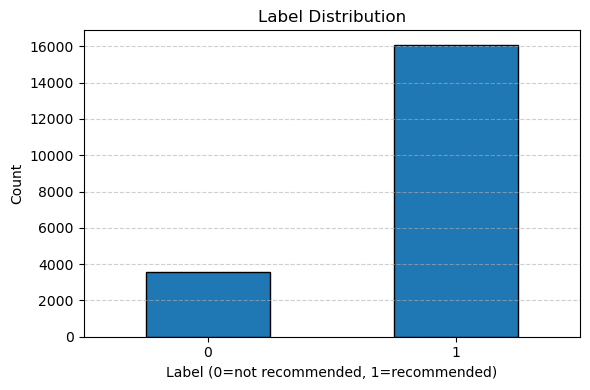

In [ ]:
LABEL_COL = "Recommended IND"  # adjust if your column is named differently
labels = df[LABEL_COL].astype(int)
vc = labels.value_counts().sort_index()
pct = (vc / len(labels) * 100).round(2)

print("Label counts:\n", vc.to_string())
print("\nLabel %:\n", pct.to_string())

# Imbalance ratio = minority / majority
maj = vc.idxmax()
minr = vc.idxmin()
imb_ratio = vc[minr] / vc[maj] if vc[maj] > 0 else np.nan
print(f"\nImbalance ratio (minority/majority): {imb_ratio:.3f}")


In [ ]:
# Plot
plt.figure(figsize=(6,4))
vc.plot(kind="bar", edgecolor="black")
plt.title("Label Distribution")
plt.xlabel("Label (0=not recommended, 1=recommended)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

,count,mean,std,min,50%,75%,90%,95%,max
_review_chars,19652.0,121.455628,60.054070,3.0,118.0,170.0,203.0,220.0,304.0
_review_tokens,19652.0,18.090016,8.826573,1.0,18.0,25.0,30.0,32.0,47.0
_title_chars,19652.0,19.100346,9.580951,2.0,17.0,24.0,33.0,38.0,52.0
_title_tokens,19652.0,3.249033,1.707047,0.0,3.0,4.0,6.0,7.0,12.0


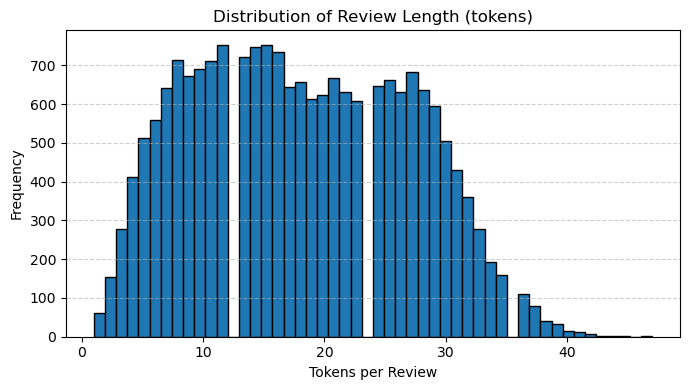

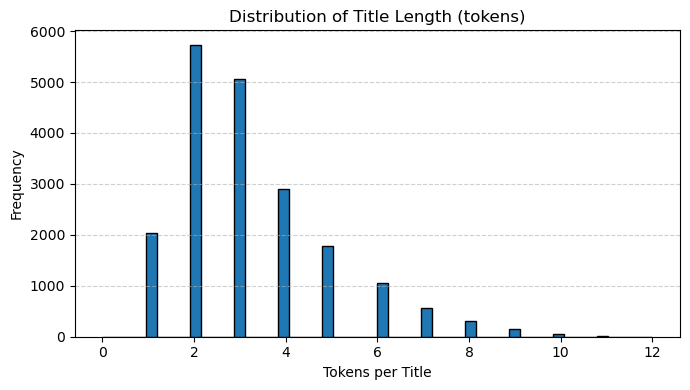

In [47]:
# Consistent tokenizer (same as Task 1)
tokenizer = re.compile(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")

def tokenize(text):
    if not isinstance(text, str):
        return []
    toks = tokenizer.findall(text.lower())
    return [t.strip("-'") for t in toks if len(t.strip("-'")) >= 2]

# Compute lengths
df["_review_chars"] = df["Review Text"].astype(str).str.len()
df["_review_tokens"] = df["Review Text"].astype(str).apply(lambda x: len(tokenize(x)))
df["_title_chars"] = df["Title"].astype(str).str.len()
df["_title_tokens"] = df["Title"].astype(str).apply(lambda x: len(tokenize(x)))

# Summary stats
length_cols = ["_review_chars","_review_tokens","_title_chars","_title_tokens"]
desc = df[length_cols].describe(percentiles=[0.5,0.75,0.9,0.95]).T
display(desc)

# Histograms (tokens)
plt.figure(figsize=(7,4))
plt.hist(df["_review_tokens"], bins=50, edgecolor="black")
plt.title("Distribution of Review Length (tokens)")
plt.xlabel("Tokens per Review")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(df["_title_tokens"], bins=50, edgecolor="black")
plt.title("Distribution of Title Length (tokens)")
plt.xlabel("Tokens per Title")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [48]:
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vocab_lines = [ln.strip() for ln in f if ln.strip()]

# Basic size
print("Vocabulary size:", len(vocab_lines))

# Preview first 10 entries
print("\nFirst 10 vocab entries:")
for ln in vocab_lines[:10]:
    print(ln)

# Parse into dict to verify ordering and indices
def parse_vocab_line(ln):
    # expected "word:index"
    try:
        word, idx = ln.split(":")
        return word, int(idx)
    except Exception:
        return None, None

vocab_pairs = [parse_vocab_line(ln) for ln in vocab_lines]
vocab_pairs = [(w, i) for w, i in vocab_pairs if w is not None]

# Check: indices start at 0 and strictly increase by 1
indices = [i for _, i in vocab_pairs]
monotonic = indices == list(range(len(indices)))
print("\nIndex sequence valid (0..N-1):", monotonic)

# Check alphabetical order of words
words = [w for w, _ in vocab_pairs]
alphabetical = words == sorted(words)
print("Words sorted alphabetically:", alphabetical)


Vocabulary size: 7529

First 10 vocab entries:
a-cup:0
a-flutter:1
a-frame:2
a-kind:3
a-line:4
a-lines:5
a-symmetric:6
aa:7
ab:8
abbey:9

Index sequence valid (0..N-1): True
Words sorted alphabetically: True


In [49]:
grouped = df.groupby(labels).agg(
    review_tokens_mean=("_review_tokens","mean"),
    review_tokens_median=("_review_tokens","median"),
    title_tokens_mean=("_title_tokens","mean"),
    title_tokens_median=("_title_tokens","median"),
    review_chars_mean=("_review_chars","mean"),
    title_chars_mean=("_title_chars","mean"),
    n=("Review Text","count")
).round(2)

display(grouped)

,review_tokens_mean,review_tokens_median,title_tokens_mean,title_tokens_median,review_chars_mean,title_chars_mean,n
Recommended IND,,,,,,,
0,18.38,18.0,3.58,3.0,124.17,20.26,3575
1,18.03,18.0,3.17,3.0,120.85,18.84,16077


Top tokens (overall):


,token,freq
0,bit,2582
1,beautiful,2491
2,large,2485
3,material,2438
4,length,2366
5,sweater,2254
6,shirt,2230
7,petite,2179
8,long,2154
9,jeans,2134



Top tokens (class=1, recommended):


,token,freq
0,bit,2301
1,beautiful,2087
2,length,2075
3,large,2008
4,jeans,1981
5,petite,1877
6,long,1858
7,colors,1845
8,sweater,1830
9,material,1799



Top tokens (class=0, not recommended):


,token,freq
0,material,639
1,shirt,573
2,looked,516
3,large,477
4,quality,476
5,made,452
6,work,450
7,sweater,424
8,wanted,416
9,short,408


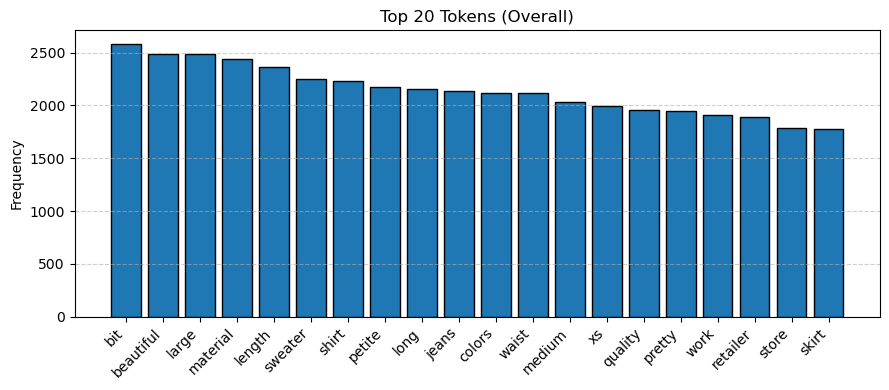

In [50]:
# Build token lists
all_tokens = []
pos_tokens = []
neg_tokens = []

for text, lab in zip(df["Review Text"].astype(str), labels):
    toks = tokenize(text)
    all_tokens.extend(toks)
    if lab == 1:
        pos_tokens.extend(toks)
    else:
        neg_tokens.extend(toks)

top_k = 20
overall_top = Counter(all_tokens).most_common(top_k)
pos_top = Counter(pos_tokens).most_common(15)
neg_top = Counter(neg_tokens).most_common(15)

print("Top tokens (overall):")
display(pd.DataFrame(overall_top, columns=["token","freq"]))

print("\nTop tokens (class=1, recommended):")
display(pd.DataFrame(pos_top, columns=["token","freq"]))

print("\nTop tokens (class=0, not recommended):")
display(pd.DataFrame(neg_top, columns=["token","freq"]))

# Bar plot overall
tokens, freqs = zip(*overall_top) if overall_top else ([], [])
plt.figure(figsize=(9,4))
plt.bar(tokens, freqs, edgecolor="black")
plt.title("Top 20 Tokens (Overall)")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
# def clean_reviews(text_series, stopwords):
#     """
#     Cleans a series of text documents by tokenizing, removing stopwords,
#     rare words (frequency=1), and the top 20 most frequent words.
#     Returns the cleaned tokens and a vocabulary mapping.
#     """
#     def initial_clean(text):
#         if not isinstance(text, str):
#             return []
#         # Find tokens, allowing for hyphens and apostrophes within words
#         tokens = re.findall(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?", text)
#         tokens = [word.lower() for word in tokens if len(word) >= 2]
#         return [word for word in tokens if word not in stopwords]

#     print("Performing initial tokenization and cleaning...")
#     processed_tokens = text_series.fillna('').apply(initial_clean)

#     # --- Identify words to remove ---
#     # 1. Words that appear only once in the entire corpus
#     all_tokens_flat = [token for tokens_list in processed_tokens for token in tokens_list]
#     term_freq = Counter(all_tokens_flat)
#     words_to_remove_once = {word for word, count in term_freq.items() if count == 1}

#     # 2. Top 20 most frequent words (document frequency)
#     doc_freq_counter = Counter()
#     for tokens in processed_tokens:
#         doc_freq_counter.update(set(tokens))
#     top_20_words = {word for word, _ in doc_freq_counter.most_common(20)}

#     # Combine all words to be removed
#     words_to_remove = stopwords.union(words_to_remove_once, top_20_words)
#     print(f"Identified {len(words_to_remove_once)} rare words and {len(top_20_words)} common words to remove.")

#     # --- Final cleaning pass ---
#     def final_clean(tokens):
#         return [token for token in tokens if token not in words_to_remove]

#     final_processed_tokens = processed_tokens.apply(final_clean)

#     # --- Create Vocabulary ---
#     vocab_set = sorted(set(token for tokens in final_processed_tokens for token in tokens))
#     vocab = {word: idx for idx, word in enumerate(vocab_set)}
#     print(f"Vocabulary created with {len(vocab)} unique words.")

#     return final_processed_tokens, vocab

In [19]:
# def tokens_to_bow_matrix(token_lists, vocab):
#     """Converts a list of token lists into a Bag-of-Words matrix."""
#     vocab_size = len(vocab)
#     matrix = np.zeros((len(token_lists), vocab_size), dtype=int)
#     for i, tokens in enumerate(token_lists):
#         for token in tokens:
#             if token in vocab:
#                 matrix[i, vocab[token]] += 1
#     return matrix

In [20]:
# def load_sparse_bow_vectors(path, vocab_size):
#     """Loads sparse BoW vectors from a file and returns a dense numpy array."""
#     data = []
#     with open(path, 'r') as f:
#         for line in f:
#             parts = line.strip().split(',')
#             vec = np.zeros(vocab_size)
#             # parts[0] is the document ID, so we start from parts[1:]
#             for item in parts[1:]:
#                 try:
#                     idx, freq = map(int, item.split(':'))
#                     if idx < vocab_size: # Boundary check
#                         vec[idx] = freq
#                 except ValueError:
#                     print(f"Warning: Skipping malformed item '{item}' in a line.")
#             data.append(vec)
#     return np.array(data)

In [21]:
# def load_dense_vectors(path):
#     """Loads dense embedding vectors from a file."""
#     data = []
#     with open(path, 'r') as f:
#         for line in f:
#             parts = line.strip().split(',')
#             # Assumes the first part is an ID/index and the rest are vector components
#             data.append([float(x) for x in parts[1:]])
#     return np.array(data)

### Data Loading and Feature Engineering

In [22]:
# # Load stopwords
# try:
#     with open("../data/stopwords_en.txt", "r", encoding="utf-8") as f:
#         stopwords = set(line.strip().lower() for line in f if line.strip())
# except FileNotFoundError:
#     print("Warning: stopwords_en.txt not found. Proceeding without stopwords.")
#     stopwords = set()

# # Load main dataset and labels
# df = pd.read_csv("../output/processed.csv")
# # Ensure we are using the same slice of data for all features and labels
# y = df['Recommended IND'].values[:19652]

# # --- Feature Set: Review Text BoW ---
# try:
#     with open("../output/vocab.txt", "r", encoding="utf-8") as f:
#         review_vocab_size = len(f.readlines())
#     print(f"Determined review vocabulary size: {review_vocab_size}")
#     X_review_bow = load_sparse_bow_vectors("../output/count_vectors.txt", vocab_size=review_vocab_size)
# except FileNotFoundError:
#     print("Fatal Error: ../output/vocab.txt or ../output/count_vectors.txt not found. Cannot proceed.")
#     X_review_bow = np.empty((len(y), 0))

# # --- Feature Set: Review Title BoW ---
# print("\nProcessing 'Title' column to create Title BoW features...")
# title_series = df['Title'][:19652]
# title_cleaned_tokens, title_vocab = clean_reviews(title_series, stopwords)
# X_title_bow = tokens_to_bow_matrix(title_cleaned_tokens, title_vocab)

# # --- Feature Set: Combined BoW ---
# X_combined_bow = np.concatenate([X_review_bow, X_title_bow], axis=1)

# # --- Feature Sets: Precomputed Embeddings ---
# print("\nLoading pre-computed embedding vectors...")
# X_unweighted = load_dense_vectors("../output/unweighted_vectors.txt")
# X_weighted = load_dense_vectors("../output/weighted_vectors.txt")

# # --- Final Check ---
# print("\n--- Feature Matrix Shapes ---")
# print(f"Review BoW:      {X_review_bow.shape}")
# print(f"Title BoW:       {X_title_bow.shape}")
# print(f"Combined BoW:    {X_combined_bow.shape}")
# print(f"Unweighted Emb:  {X_unweighted.shape}")
# print(f"Weighted Emb:    {X_weighted.shape}")
# print(f"Labels (y):      {y.shape}")
# print("-----------------------------\n")

### Question 1

Which language model we built previously (based on clothing reviews) performs the best with the 
chosen machine learning model? To answer these questions, you are required to build machine learning 
models based on the feature representations of the documents you generated in Task 2, and to perform 
evaluation on the various model performance.

### Target Variable

In [ ]:
# # --- Imbalance diagnostics (binary labels expected: 0/1) ---
# labels = pd.Series(y).astype(int)
# counts = counts_sorted = labels.value_counts().sort_index()  # index 0 then 1
# maj_class = counts_sorted.idxmax()
# min_class = counts_sorted.idxmin()
# imb_ratio = counts_sorted[min_class] / counts_sorted[maj_class]  # minority / majority

# print("Label counts:")
# print(counts_sorted.to_string())
# print(f"\nImbalance ratio (minority/majority): {imb_ratio:.3f}")

# import matplotlib.pyplot as plt

# plt.figure(figsize=(7, 4))
# counts_sorted.plot(kind='bar', edgecolor='black')
# plt.title('Label Distribution')
# plt.xlabel('Label')
# plt.ylabel('Frequency')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


NameError: name 'y' is not defined

In [ ]:
# # --- SMOTE done the right way: only on training folds via an imblearn Pipeline ---
# # (Using X_review_bow as the text feature set you want to balance.)
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
# from sklearn.model_selection import StratifiedKFold, cross_validate
# from sklearn.linear_model import LogisticRegression

# # Safety: choose k_neighbors based on the minority class size
# minority_n = counts_sorted[min_class]
# # SMOTE needs k_neighbors < minority_n and >= 1
# k_safe = max(1, min(5, minority_n - 1))

# print(f"SMOTE k_neighbors set to {k_safe} (minority_n={minority_n})")

# # Guard: skip SMOTE if you have no features loaded
# if X_review_bow.size == 0:
#     raise ValueError("X_review_bow is empty — cannot apply SMOTE or train models.")

# # Define a simple model; swap in your model of choice later
# clf = LogisticRegression(max_iter=1000, n_jobs=-1)

# pipe = ImbPipeline(steps=[
#     ('smote', SMOTE(k_neighbors=k_safe, random_state=42)),
#     ('clf', clf),
# ])

# # Use stratified CV and metrics that reflect imbalance
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_validate(
#     pipe,
#     X_review_bow,
#     y,
#     cv=cv,
#     scoring={
#         'f1': 'f1',
#         'roc_auc': 'roc_auc',
#         'balanced_acc': 'balanced_accuracy',
#         'precision': 'precision',
#         'recall': 'recall',
#     },
#     n_jobs=-1,
#     return_train_score=False,
# )

# import pandas as pd
# summary = pd.DataFrame(scores).agg(['mean', 'std']).T
# print("\nCV with in-fold SMOTE — metrics (mean ± std):")
# print(summary.to_string(float_format=lambda x: f"{x:.4f}"))

SMOTE k_neighbors set to 5 (minority_n=3575)

CV with in-fold SMOTE — metrics (mean ± std):
                      mean    std
fit_time          158.8864 2.7576
score_time          0.1326 0.0737
test_f1             0.8985 0.0040
test_roc_auc        0.8735 0.0056
test_balanced_acc   0.7901 0.0082
test_precision      0.9313 0.0036
test_recall         0.8680 0.0072


In [ ]:
# from sklearn.model_selection import StratifiedKFold, cross_validate
# from sklearn.linear_model import LogisticRegression
# import pandas as pd

# clf = LogisticRegression(max_iter=1000, n_jobs=-1)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# baseline_scores = cross_validate(
#     clf,
#     X_review_bow,
#     y,
#     cv=cv,
#     scoring={
#         'f1': 'f1',
#         'roc_auc': 'roc_auc',
#         'balanced_acc': 'balanced_accuracy',
#         'precision': 'precision',
#         'recall': 'recall',
#     },
#     n_jobs=-1,
#     return_train_score=False,
# )

# baseline_summary = pd.DataFrame(baseline_scores).agg(['mean', 'std']).T
# print("CV without imbalance handling:")
# print(baseline_summary.to_string(float_format=lambda x: f"{x:.4f}"))

CV without imbalance handling:
                     mean    std
fit_time          57.7644 1.2252
score_time         0.1320 0.0881
test_f1            0.9258 0.0022
test_roc_auc       0.8908 0.0054
test_balanced_acc  0.7487 0.0067
test_precision     0.9044 0.0027
test_recall        0.9483 0.0045


In [ ]:
# smote_summary = pd.DataFrame(scores).agg(['mean', 'std']).T

# comparison = pd.concat(
#     {'No SMOTE': baseline_summary['mean'], 'SMOTE': smote_summary['mean']},
#     axis=1
# )
# print("\nComparison of metrics (5-fold CV):")
# print(comparison)


Comparison of metrics (5-fold CV):
                   No SMOTE    SMOTE
fit_time            57.7644 158.8864
score_time           0.1320   0.1326
test_f1              0.9258   0.8985
test_roc_auc         0.8908   0.8735
test_balanced_acc    0.7487   0.7901
test_precision       0.9044   0.9313
test_recall          0.9483   0.8680


In [ ]:
# # =============================================================================
# # SECTION 4: Q1 - Language Model Comparisons
# # =============================================================================
# print("--- Starting Evaluation for Q1: Comparing Language Models on Review Text ---")
# RANDOM_STATE = 42
# cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# scoring_metrics = {"acc": "accuracy", "f1": "f1_weighted"}

# # Define feature sets for Q1
# feature_sets_q1 = {
#     "Review BoW": X_review_bow,
#     "Embeddings (Unweighted)": X_unweighted,
#     "Embeddings (Weighted)": X_weighted,
# }

# # Define models for each feature type
# sparse_models = {
#     "LogReg (liblinear)": LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
#     "LinearSVM": LinearSVC(max_iter=2000, random_state=RANDOM_STATE),
#     "MultinomialNB": MultinomialNB(),
# }

# def create_dense_pipeline(estimator):
#     return Pipeline([("scaler", StandardScaler()), ("clf", estimator)])

# dense_models = {
#     "LogReg": create_dense_pipeline(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
#     "LinearSVM": create_dense_pipeline(LinearSVC(max_iter=2000, random_state=RANDOM_STATE)),
#     "HistGB": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
#     "MLP(256, ES)": create_dense_pipeline(MLPClassifier(hidden_layer_sizes=(256,), max_iter=300, early_stopping=True, n_iter_no_change=10, random_state=RANDOM_STATE)),
# }

# # Run CV for Q1
# results_list_q1 = []
# for feat_name, X in feature_sets_q1.items():
#     print(f"\nEvaluating feature set for Q1: '{feat_name}'...")
#     models_to_run = sparse_models if "BoW" in feat_name else dense_models
#     for mdl_name, mdl in models_to_run.items():
#         print(f"  -> Running model: '{mdl_name}'...")
#         cv_results = cross_validate(mdl, X, y, scoring=scoring_metrics, cv=cv_strategy, n_jobs=-1)
#         results_list_q1.append({
#             "Feature Set": feat_name, "Model": mdl_name,
#             "Accuracy (mean)": np.mean(cv_results["test_acc"]), "F1 (mean)": np.mean(cv_results["test_f1"])
#         })

# # Format and Display Results for Q1
# results_df_q1 = pd.DataFrame(results_list_q1).sort_values(by="F1 (mean)", ascending=False).reset_index(drop=True)
# print("\n\n--- RESULTS FOR Q1: Language Model Comparisons ---")
# pd.options.display.float_format = "{:.4f}".format
# print(results_df_q1)

--- Starting Evaluation for Q1: Comparing Language Models on Review Text ---

Evaluating feature set for Q1: 'Review BoW'...
  -> Running model: 'LogReg (liblinear)'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'MultinomialNB'...

Evaluating feature set for Q1: 'Embeddings (Unweighted)'...
  -> Running model: 'LogReg'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'HistGB'...
  -> Running model: 'MLP(256, ES)'...

Evaluating feature set for Q1: 'Embeddings (Weighted)'...
  -> Running model: 'LogReg'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'HistGB'...
  -> Running model: 'MLP(256, ES)'...


--- RESULTS FOR Q1: Language Model Comparisons ---
                Feature Set               Model  Accuracy (mean)  F1 (mean)
0                Review BoW       MultinomialNB           0.8737     0.8739
1                Review BoW  LogReg (liblinear)           0.8750     0.8688
2                Review BoW           LinearSVM           0.8566     0.8545
3   Em

### Q2

In [ ]:
# # =============================================================================
# # SECTION 5: Q2 - Does More Information Provide Higher Accuracy?
# # =============================================================================
# print("\n\n--- Starting Evaluation for Q2: Comparing Title, Review, and Combined Text ---")

# # Define feature sets for Q2 (all are BoW-based)
# feature_sets_q2 = {
#     "Title BoW Only": X_title_bow,
#     "Review BoW Only": X_review_bow,
#     "Combined BoW": X_combined_bow,
# }

# # Run CV for Q2
# results_list_q2 = []
# for feat_name, X in feature_sets_q2.items():
#     print(f"\nEvaluating feature set for Q2: '{feat_name}'...")
#     # For Q2, we compare BoW representations, so we use sparse models.
#     for mdl_name, mdl in sparse_models.items():
#         print(f"  -> Running model: '{mdl_name}'...")
#         cv_results = cross_validate(mdl, X, y, scoring=scoring_metrics, cv=cv_strategy, n_jobs=-1)
#         results_list_q2.append({
#             "Feature Set": feat_name, "Model": mdl_name,
#             "Accuracy (mean)": np.mean(cv_results["test_acc"]), "F1 (mean)": np.mean(cv_results["test_f1"])
#         })

# # Format and Display Results for Q2
# results_df_q2 = pd.DataFrame(results_list_q2).sort_values(by=["Feature Set", "F1 (mean)"], ascending=[True, False]).reset_index(drop=True)
# print("\n\n--- RESULTS FOR Q2: Impact of Additional Information (Title) ---")
# print(results_df_q2)



--- Starting Evaluation for Q2: Comparing Title, Review, and Combined Text ---

Evaluating feature set for Q2: 'Title BoW Only'...
  -> Running model: 'LogReg (liblinear)'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'MultinomialNB'...

Evaluating feature set for Q2: 'Review BoW Only'...
  -> Running model: 'LogReg (liblinear)'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'MultinomialNB'...

Evaluating feature set for Q2: 'Combined BoW'...
  -> Running model: 'LogReg (liblinear)'...
  -> Running model: 'LinearSVM'...
  -> Running model: 'MultinomialNB'...


--- RESULTS FOR Q2: Impact of Additional Information (Title) ---
       Feature Set               Model  Accuracy (mean)  F1 (mean)
0     Combined BoW       MultinomialNB           0.8922     0.8941
1     Combined BoW  LogReg (liblinear)           0.8881     0.8836
2     Combined BoW           LinearSVM           0.8723     0.8710
3  Review BoW Only       MultinomialNB           0.8737     0.8739
4  Revie

## Summary
Give a short summary and anything you would like to talk about the assessment tasks here.

## Couple of notes for all code blocks in this notebook
- please provide proper comment on your code
- Please re-start and run all cells to make sure codes are runable and include your output in the submission.   
<span style="color: red"> This markdown block can be removed once the task is completed. </span>